In [1]:
import os

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [3]:
base_dir = './floorplans/binary classification dataset/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training floorplans pictures
train_floorplans_dir = os.path.join(train_dir, 'floorplans')

# Directory with our training notfloorplans pictures
train_notfloorplans_dir = os.path.join(train_dir, 'notfloorplans')

# Directory with our validation floorplans pictures
validation_floorplans_dir = os.path.join(validation_dir, 'floorplans')

# Directory with our validation notfloorplans pictures
validation_notfloorplans_dir = os.path.join(validation_dir, 'notfloorplans')

In [4]:
print('total training floorplans images:', len(os.listdir(train_floorplans_dir)))
print('total training notfloorplans images:', len(os.listdir(train_notfloorplans_dir)))
print('total validation floorplans images:', len(os.listdir(validation_floorplans_dir)))
print('total validation notfloorplans images:', len(os.listdir(validation_notfloorplans_dir)))

total training floorplans images: 500
total training notfloorplans images: 500
total validation floorplans images: 251
total validation notfloorplans images: 250


In [5]:
train_floorplan_fnames = os.listdir(train_floorplans_dir)
print(train_floorplan_fnames[:10])

train_notfloorplan_fnames = os.listdir(train_notfloorplans_dir)
train_notfloorplan_fnames.sort()
print(train_notfloorplan_fnames[:10])

class_labels = ['floorplans', 'notfloorplans']

['floorplan.213.jpg', 'floorplan.207.jpg', 'floorplan.69.jpg', 'floorplan.41.jpg', 'floorplan.55.jpg', 'floorplan.82.jpg', 'floorplan.96.jpg', 'floorplan.165.jpg', 'floorplan.171.jpg', 'floorplan.159.jpg']
['notfloorplan0.jpg', 'notfloorplan1.jpg', 'notfloorplan10.jpg', 'notfloorplan100.jpg', 'notfloorplan101.jpg', 'notfloorplan102.jpg', 'notfloorplan103.jpg', 'notfloorplan104.jpg', 'notfloorplan105.jpg', 'notfloorplan106.jpg']


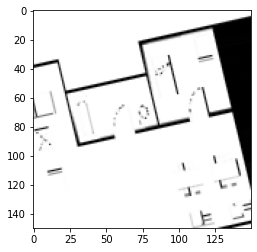

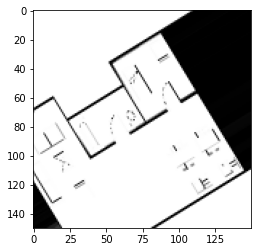

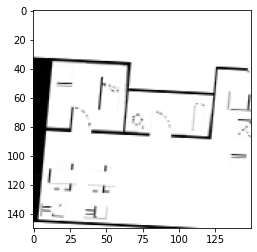

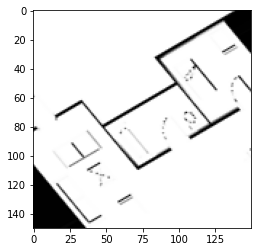

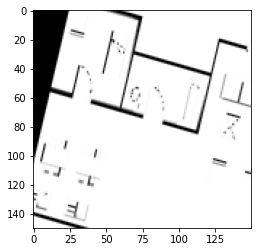

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_floorplans_dir, train_floorplan_fnames[4])
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

In [7]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [8]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

In [10]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=25,  # 500 images = batch_size * steps
      epochs=30,
      validation_data=validation_generator,
      validation_steps=25,  # 250 images = batch_size * steps
      verbose=2)

/Users/areebakamil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 - 35s - loss: 1.6422 - acc: 0.6800 - val_loss: 0.3084 - val_acc: 0.9360
Epoch 2/30
25/25 - 32s - loss: 0.3267 - acc: 0.9040 - val_loss: 0.1693 - val_acc: 0.9520
Epoch 3/30
25/25 - 31s - loss: 0.2997 - acc: 0.8920 - val_loss: 0.2389 - val_acc: 0.9560
Epoch 4/30
25/25 - 28s - loss: 0.2261 - acc: 0.9240 - val_loss: 0.2008 - val_acc: 0.9520
Epoch 5/30
25/25 - 33s - loss: 0.1877 - acc: 0.9500 - val_loss: 0.0872 - val_acc: 0.9840
Epoch 6/30
25/25 - 32s - loss: 0.2066 - acc: 0.9440 - val_loss: 0.1570 - val_acc: 0.9560
Epoch 7/30
25/25 - 34s - loss: 0.1553 - acc: 0.9540 - val_loss: 0.3569 - val_acc: 0.9440
Epoch 8/30
25/25 - 31s - loss: 0.1082 - acc: 0.9700 - val_loss: 0.2178 - val_acc: 0.9480
Epoch 9/30
25/25 - 34s - loss: 0.1734 - acc: 0.9460 - val_loss: 0.2207 - val_acc: 0.9640
Epoch 10/30
25/25 - 33s - loss: 0.1193 - acc: 0.9720 - val_loss: 0.1486 - val_acc: 0.9800
Epoch 11/30
25/25 - 32s - loss: 0.1396 - acc: 0.9700 - val_loss: 0.0804 - val_acc: 0.9720
Epoch 12/30
25/25 -

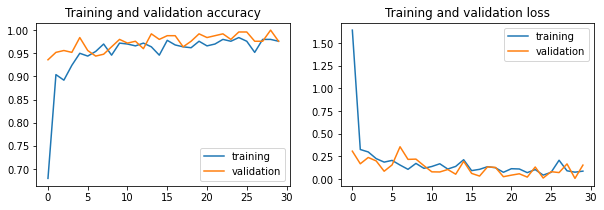

In [11]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(3)

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.title('Training and validation accuracy')
plt.legend(loc='best')

# plt.figure()

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.title('Training and validation loss')
plt.legend(loc='best')

plt.show()


In [12]:
model.save("image_classification_v2")

INFO:tensorflow:Assets written to: image_classification_v2/assets


In [13]:

# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np

# # printing a confusion matrix
# #Confution Matrix and Classification Report
# batch_size = 20
# num_of_test_samples = 100
# Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
# y_pred = np.argmax(Y_pred, axis=1)

# print('Confusion Matrix')
# print(confusion_matrix(validation_generator.classes, y_pred))
# print('Classification Report')
# target_names = ['floorplans', 'NOTfloorplans']
# print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


In [14]:
# testing the classifier
import numpy as np

def preprocess_image(image_path):
  img = load_img(image_path, target_size=(150, 150))  # this is a PIL image
  x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
  x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

  # Rescale by 1/255
  x /= 255
  return x


In [15]:
def make_predictions(test_folder_path):
    predicted_labels = []
    probabilities = []
    paths = []
    images = []

    
    test_image_names = os.listdir(test_folder_path)

    for img in test_image_names:
        if img == '.DS_Store':
            continue
        else:
            img_path = os.path.join(test_folder_path, img)
            paths.append(img_path)
            read_image = plt.imread(img_path) 
            images.append(read_image)

            processed_img = preprocess_image(img_path)

            prediction_probability = model.predict(processed_img)
    #         print(img_path)
            pred = np.squeeze(prediction_probability[0])
            output = f"{pred:.15f}"
            print(output)
            probabilities.append(output)

            label = None
            if pred < 0.5:
                label = 'floorplan'
            else:
                label = 'NOTfloorplan'

            predicted_labels.append(label)

    #         print("This image most likely belongs to {} class.\n".format(label))
    
    return images, predicted_labels,probabilities,paths


  

In [16]:
# Access images in the test folder
test_dir = os.path.join(base_dir, 'test')

print(os.listdir(test_dir))

# Different directories with test images
basic_floorplans_dir = os.path.join(test_dir, 'basic_floorplans2')
colored_floorplans_dir = os.path.join(test_dir, 'colored_floorplans2')
hand_drawn_plans_dir = os.path.join(test_dir, 'hand_drawn_plans2')
hand_drawn_plans_with_graph_dir = os.path.join(test_dir, 'hand_drawn_plans_with_graph2')
text_documents_dir = os.path.join(test_dir, 'text_documents2')
document_with_tables_dir = os.path.join(test_dir, 'documents_with_tables2')


['basic_floorplans2', 'documents_with_tables2', '.DS_Store', 'hand_drawn_plans_with_graph2', 'hand_drawn_plans2', 'text_documents2', 'colored_floorplans2']


In [17]:
# Display predictions

def display_results(images, predicted_labels, paths):
    
    for i in range(len(paths)):
        #rows, cols, index of img
        plt.subplot(3,4, i+1), plt.imshow(images[i], 'gray')
        
        plt.title(predicted_labels[i])
        plt.xticks([]), plt.yticks([])
        plt.figure(figsize=(20, 20))

    plt.show()



0.000000000000542
0.000000000000000
0.067126065492630
0.000000020412177
0.975150346755981
0.000000000000007
0.000000000000124
0.000000000231202
0.000000000000000
0.000000000000000
0.000000000000000


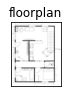

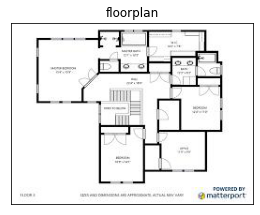

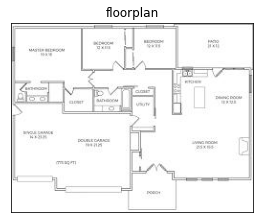

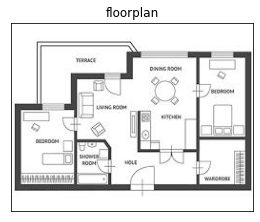

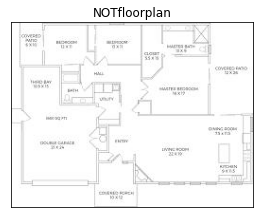

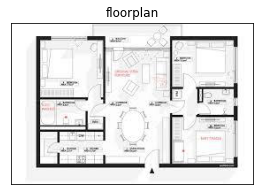

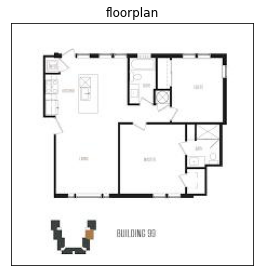

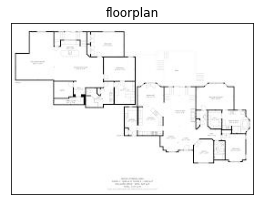

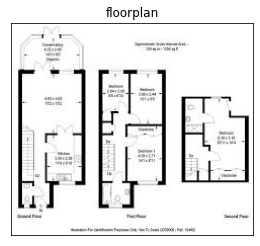

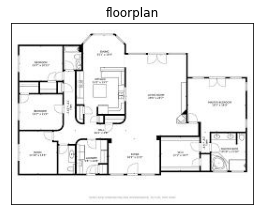

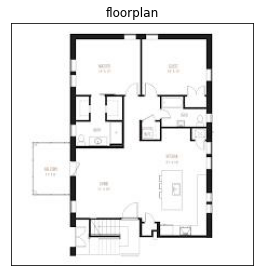

<Figure size 1440x1440 with 0 Axes>

In [18]:
images = []
predicted_labels = []
probabilities = []
paths = []

images, predicted_labels, probabilities, paths = make_predictions(basic_floorplans_dir)
display_results(images,predicted_labels, paths)

0.000001318662271
0.000000001807631
0.000004820914000
0.000000000023139
0.000000000000013
0.000000016380104
0.000000000000214
0.000000000000001
0.000000000000002


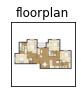

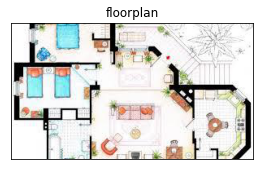

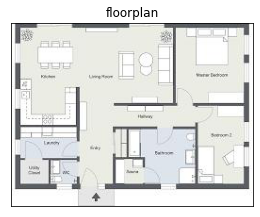

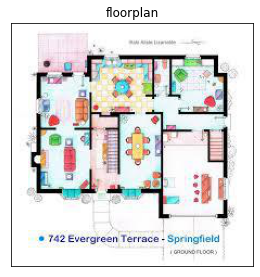

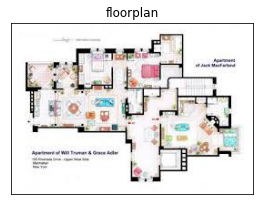

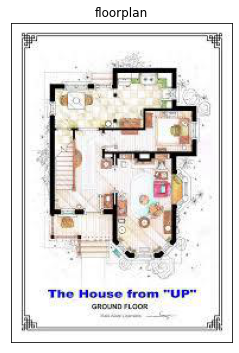

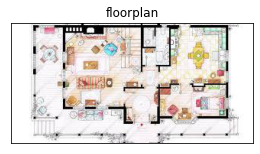

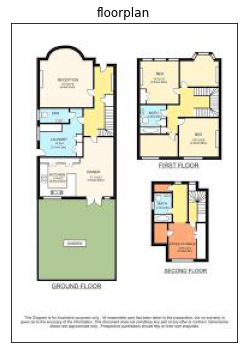

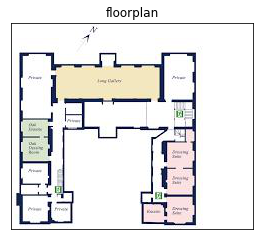

<Figure size 1440x1440 with 0 Axes>

In [19]:
images = []
predicted_labels = []
probabilities = []
paths = []

images, predicted_labels, probabilities, paths = make_predictions(colored_floorplans_dir)
display_results(images,predicted_labels, paths)


0.000000000120747
0.000003298320962
0.000130832195282
0.001001775264740
0.577814221382141
0.000000000000000


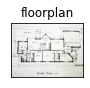

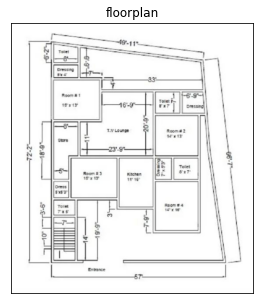

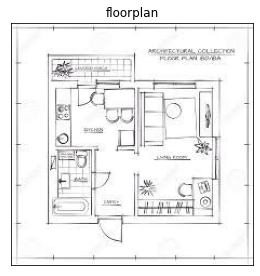

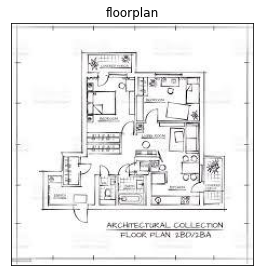

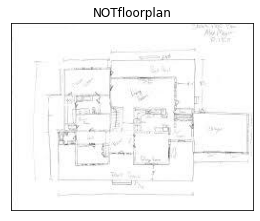

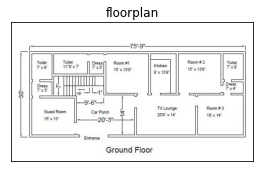

<Figure size 1440x1440 with 0 Axes>

In [20]:
images = []
predicted_labels = []
probabilities = []
paths = []

images, predicted_labels, probabilities, paths = make_predictions(hand_drawn_plans_dir)
display_results(images,predicted_labels, paths)


0.000000000000043
0.427250266075134
0.976234078407288
0.046979755163193
0.941835403442383


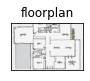

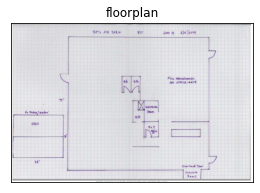

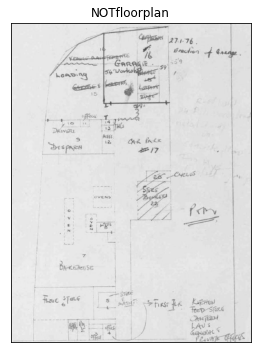

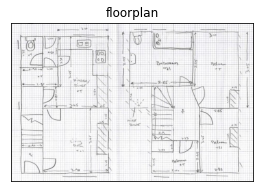

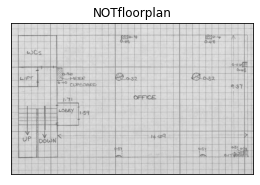

<Figure size 1440x1440 with 0 Axes>

In [21]:
images = []
predicted_labels = []
probabilities = []
paths = []

images, predicted_labels, probabilities, paths = make_predictions(hand_drawn_plans_with_graph_dir)
display_results(images,predicted_labels, paths)

0.996737420558929
0.995211601257324
0.994856953620911
0.995400786399841
0.997286081314087
0.996191382408142


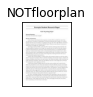

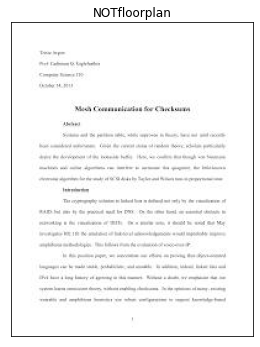

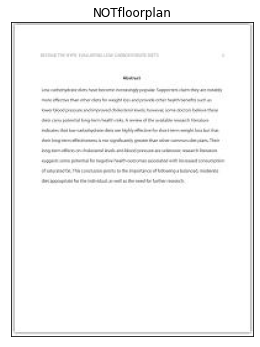

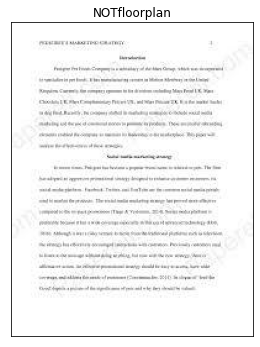

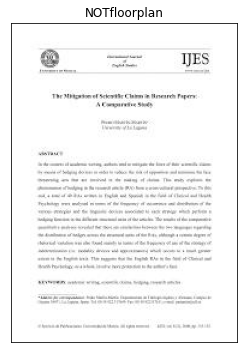

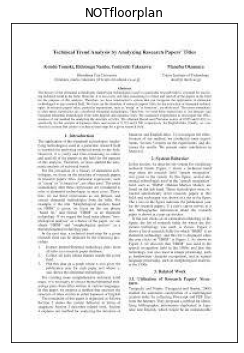

<Figure size 1440x1440 with 0 Axes>

In [22]:
images = []
predicted_labels = []
probabilities = []
paths = []

images, predicted_labels, probabilities, paths = make_predictions(text_documents_dir)
display_results(images,predicted_labels, paths)

0.013705492019653
0.995675921440125
0.785904049873352
0.998689413070679
0.000000458615489


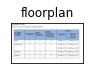

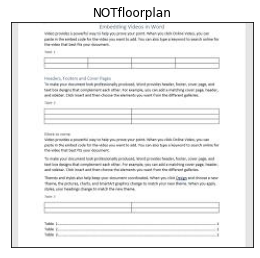

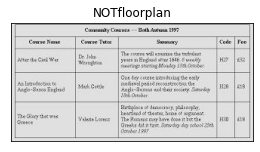

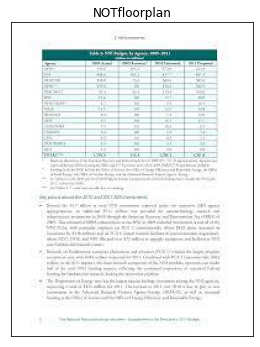

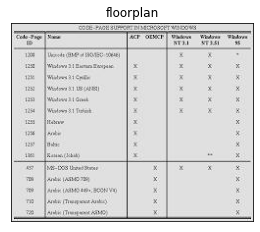

<Figure size 1440x1440 with 0 Axes>

In [23]:
images = []
predicted_labels = []
probabilities = []
paths = []

images, predicted_labels, probabilities, paths = make_predictions(document_with_tables_dir)
display_results(images,predicted_labels, paths)